# TMDB Movie Data Analysis Using Pyspark

In [48]:
# from utils import *
from pyspark.sql.types import StructField, StructType, BooleanType, StringType, IntegerType, DoubleType, ArrayType, LongType, FloatType
import os
from utils import *
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#declare constant variables
BASE_URL = "https://api.themoviedb.org/3/movie/"
API_ACCESS_TOKEN = os.getenv('API_ACCESS_TOKEN')
HEADERS = {
    "accept": "application/json",
    "Authorization": f"Bearer {API_ACCESS_TOKEN}"
}
movie_ids = [0, 299534, 19995, 140607, 299536, 597, 135397, 420818, 24428, 168259, 99861, 284054, 12445,181808, 330457, 351286, 109445, 321612, 260513]

In [3]:
spark = create_spark_session("imdb_movie_data_analysis")

In [4]:

movie_schema = StructType([
    StructField("adult", BooleanType(), True),
    StructField("backdrop_path", StringType(), True),
    StructField("belongs_to_collection", StructType([
        StructField("backdrop_path", StringType(), True),
        StructField("name", StringType(), True),
        StructField("id", IntegerType(), True),
        StructField("poster_path", StringType(), True)
    ]), True), 
    StructField("budget", LongType(), True),
    StructField("genres", ArrayType(StructType([
        StructField("id", IntegerType(), True),
        StructField("name", StringType(), True)
    ])), True),
    StructField("homepage", StringType(), True),
    StructField("id", IntegerType(), True),
    StructField("imdb_id", StringType(), True),
    StructField("origin_country", ArrayType(StringType()), True),
    StructField("original_language", StringType(), True),
    StructField("original_title", StringType(), True),
    StructField("overview", StringType(), True),
    StructField("popularity", FloatType(), True),
    StructField("poster_path", StringType(), True),
    StructField("production_companies", ArrayType(StructType([
        StructField("id", IntegerType(), True),
        StructField("logo_path", StringType(), True),
        StructField("name", StringType(), True),
        StructField("origin_country", StringType(), True)
    ])), True),
    StructField("production_countries", ArrayType(StructType([
        StructField("iso_3166_1", StringType(), True),
        StructField("name", StringType(), True)
    ])), True),
    StructField("release_date", StringType(), True),
    StructField("revenue", LongType(), True),
    StructField("runtime", IntegerType(), True),
    StructField("spoken_languages", ArrayType(StructType([
        StructField("english_name", StringType(), True),
        StructField("iso_639_1", StringType(), True),
        StructField("name", StringType(), True)
    ])), True),
    StructField("status", StringType(), True),
    StructField("tagline", StringType(), True),
    StructField("title", StringType(), True),
    StructField("video", BooleanType(), True),
    StructField("vote_average", FloatType(), True),
    StructField("vote_count", IntegerType(), True)
])



credit_schema = StructType([
    StructField("id", IntegerType(), True),
    StructField("cast", ArrayType(
        StructType([
            StructField("adult", BooleanType(), True),
            StructField("gender", IntegerType(), True),
            StructField("id", IntegerType(), True),
            StructField("known_for_department", StringType(), True),
            StructField("name", StringType(), True),
            StructField("original_name", StringType(), True),
            StructField("popularity", DoubleType(), True),
            StructField("profile_path", StringType(), True),
            StructField("cast_id", IntegerType(), True),
            StructField("character", StringType(), True),
            StructField("credit_id", StringType(), True),
            StructField("order", IntegerType(), True)
        ])
    ), True),
    StructField("crew", ArrayType(
        StructType([
            StructField("adult", BooleanType(), True),
            StructField("gender", IntegerType(), True),
            StructField("id", IntegerType(), True),
            StructField("known_for_department", StringType(), True),
            StructField("name", StringType(), True),
            StructField("original_name", StringType(), True),
            StructField("popularity", DoubleType(), True),
            StructField("profile_path", StringType(), True),
            StructField("credit_id", StringType(), True),
            StructField("department", StringType(), True),
            StructField("job", StringType(), True)
        ])
    ), True)
])

In [5]:
internet_connection = False
movies_df = spark.createDataFrame([], schema=movie_schema)
credits_df = spark.createDataFrame([], credit_schema)

### Fetching movie data from TMDB Movie Databse API

In [6]:
if (internet_connection != False):
    movies_df,credits_df = get_all_data(spark, BASE_URL, movie_ids, HEADERS, movie_schema=movie_schema, credit_schema=credit_schema)
    movies_df.write.mode("overwrite").json('./data/movies_raw_data.json')
    credits_df.write.mode("overwrite").json('./data/credits_raw_data.json')
else:
    movies_df = spark.read.json('./data/movies_raw_data.json', schema=movie_schema)  
    credits_df = spark.read.json('./data/credits_raw_data.json', schema=credit_schema)

In [7]:
movies_df.show()

+-----+--------------------+---------------------+---------+--------------------+--------------------+------+---------+--------------+-----------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+------------+----------+-------+--------------------+--------+--------------------+--------------------+-----+------------+----------+
|adult|       backdrop_path|belongs_to_collection|   budget|              genres|            homepage|    id|  imdb_id|origin_country|original_language|      original_title|            overview|popularity|         poster_path|production_companies|production_countries|release_date|   revenue|runtime|    spoken_languages|  status|             tagline|               title|video|vote_average|vote_count|
+-----+--------------------+---------------------+---------+--------------------+--------------------+------+---------+--------------+-----------------+--------------------+--------------------+

# Data Cleaning and Preprocessing

In [8]:
#Dropping irrelevant columns
# movies_df
columns_to_drop = ['adult', 'original_title', 'imdb_id', 'video', 'homepage']
movies_df = drop_cols(movies_df, columns_to_drop)

### Evaluating json-like columns, extracting and cleaning key data points

In [9]:
#evaluating json-like columns in movie_df and credits_df
movies_df = eval_movies_json_col(movies_df)
credits_df = eval_credits_json_col(credits_df)



In [10]:
#Dropping irrelevant columns
# credits_df
credits_df = drop_cols(credits_df, ['crew'])


In [11]:
credits_df.show()

+------+--------------------+---------+---------------+---------+
|    id|                cast|cast_size|       director|crew_size|
+------+--------------------+---------+---------------+---------+
|299534|Robert Downey Jr....|      105|  Anthony Russo|      593|
| 19995|Sam Worthington|Z...|       65|  James Cameron|      986|
|140607|Harrison Ford|Mar...|      182|    J.J. Abrams|      257|
|299536|Robert Downey Jr....|       69|      Joe Russo|      724|
|168259|Vin Diesel|Paul W...|       48|      James Wan|      223|
| 99861|Robert Downey Jr....|       72|    Joss Whedon|      636|
|284054|Chadwick Boseman|...|       66|   Ryan Coogler|      557|
| 12445|Daniel Radcliffe|...|      104|    David Yates|      154|
|181808|Mark Hamill|Carri...|      110|   Rian Johnson|      213|
|330457|Kristen Bell|Idin...|       64|   Jennifer Lee|       39|
|351286|Chris Pratt|Bryce...|       39|    J.A. Bayona|      381|
|109445|Kristen Bell|Idin...|       60|   Jennifer Lee|      284|
|321612|Em

In [12]:
# combining movies df and credits df using inner join
combined_df = join_dfs(movies_df, credits_df, on='id', how='inner')

In [13]:
## Replacing invalid data with Nan
cols_with_zero_val = ['budget', 'revenue', 'runtime']
cols_with_placeholders = ['overview', 'tagline']
cols_to_musd = ['revenue', 'budget']

combined_df = replace_with_nan(combined_df, cols_with_zero_val)
combined_df = replace_known_placeholders(combined_df, cols_with_placeholders)

combined_df = convert_to_milions(combined_df, cols_to_musd)


In [14]:

#Drop Duplicate
combined_df = combined_df.drop_duplicates()

#drop unknown id and title
combined_df = combined_df.dropna(subset=['id', 'title'])

#kekep only roow where at least 1- columns have non_Non values
combined_df = combined_df.dropna(thresh=10)

# filter to include only released movies
combined_df = combined_df.filter(F.col("status") == "Released")
# #drop status column
combined_df = drop_cols(combined_df, ['status'])

In [15]:
# Replacing Movies with vote_count = 0 with avearge count per genre
combined_df = replace_zero_count_vote(combined_df)

In [16]:
#reorder columns
reordered_df = reorder_col_and_reindex(combined_df)
reordered_df.show()

+------+--------------------+--------------------+------------+--------------------+---------------------+-----------------+-----------+------------+--------------------+--------------------+----------+------------------+----------+-------+--------------------+--------------------+--------------------+--------------------+---------+---------------+---------+
|    id|               title|             tagline|release_date|              genres|belongs_to_collection|original_language|budget_musd|revenue_musd|production_companies|production_countries|vote_count|      vote_average|popularity|runtime|            overview|    spoken_languages|         poster_path|                cast|cast_size|       director|crew_size|
+------+--------------------+--------------------+------------+--------------------+---------------------+-----------------+-----------+------------+--------------------+--------------------+----------+------------------+----------+-------+--------------------+-----------------

## KPI Implementation & Analysis

### Identifying the Best/Wok Performing Movies

In [17]:
# Finding the highest Rank
def kpi_implementation(df):
    kpi_results = {}

    #movie with the highest revenue
    kpi_results['highest_revenue'] = get_topmost(rank_movies_with_col(df, 'revenue_musd'), 'title')

    # #movie with the highest budget
    kpi_results['highest_budget'] = get_topmost(rank_movies_with_col(df, 'budget_musd'), 'title')

    #movie with the highest and lowest profit
    df = df.withColumn('profit_musd', F.col('revenue_musd') - F.col('budget_musd')) # column for profit
    kpi_results['highest_profit'] = get_topmost(rank_movies_with_col(df, 'profit_musd'), 'title')
    kpi_results['lowest_profit'] = get_topmost(rank_movies_with_col(df, 'profit_musd', asc=True), 'title')

    #movie with the highest vote count
    kpi_results['most_voted'] = get_topmost(rank_movies_with_col(df, 'vote_count'), 'title')

     #movie with the highest popularity
    kpi_results['most_pupular'] = get_topmost(rank_movies_with_col(df, 'popularity'), 'title')
 
    #movie with the highest and lowest roi
    filtered_df = cal_roi(df) # generate a df with roi column 
    kpi_results['highest_roi'] = get_topmost(rank_movies_with_col(filtered_df, 'roi_musd'), 'title')
    kpi_results['lowest_roi'] = get_topmost(rank_movies_with_col(filtered_df, 'roi_musd', asc=True), 'title')

    #movie with the highest and lowest profit
    filtered_df = df.filter(F.col('vote_count') >= 10)
    kpi_results['highest_rated'] = get_topmost(rank_movies_with_col(filtered_df, 'vote_average'), 'title')
    kpi_results['lowest_rated'] = get_topmost(rank_movies_with_col(filtered_df, 'vote_average', asc=True), 'title')

    return kpi_results


kpi_implementation(reordered_df)

{'highest_revenue': Row(title='Avatar'),
 'highest_budget': Row(title='Avengers: Age of Ultron'),
 'highest_profit': Row(title='Avatar'),
 'lowest_profit': Row(title='Avengers: Age of Ultron'),
 'most_voted': Row(title='Avatar'),
 'most_pupular': Row(title='Avengers: Infinity War'),
 'highest_roi': Row(title='Avatar'),
 'lowest_roi': Row(title='Avengers: Age of Ultron'),
 'highest_rated': Row(title='Avengers: Endgame'),
 'lowest_rated': Row(title='Jurassic World: Fallen Kingdom')}

In [18]:
# The best-rated Science Fiction Action movies starring Bruce Willis (sorted by Rating - highest to lowest).
def get_best_scifi_action_movies_with_actor(df, actor_name='Bruce Willis'):
    genre_filter = (
        F.col('genres').contains('Science Fiction') &
        F.col('genres').contains('Action')
    )

    actor_filter = F.col('cast').contains(actor_name)
    return rank_movies_with_col(df.filter(genre_filter & actor_filter), 'vote_average').select('title', 'genres', 'vote_average')
get_best_scifi_action_movies_with_actor(reordered_df).show(5)

+-----+------+------------+
|title|genres|vote_average|
+-----+------+------------+
+-----+------+------------+



In [19]:
# Movies starring Uma Thurman, directed by Quentin Tarantino (sorted by runtime - shortest to longest). 

def get_starring_directed_by(df, starring, directed_by):
    starring_filter = F.lit(True)
    for star in starring:
       starring_filter = starring_filter & F.col('cast').contains(star)

    director_filter = F.col('director') == directed_by
    
    return rank_movies_with_col(df.filter(starring_filter & director_filter), 'runtime').select('title', 'cast', 'director', 'runtime', 'vote_average')

get_starring_directed_by(reordered_df, ['Uma Thurman'], 'Quentin Tarantino').show()

+-----+----+--------+-------+------------+
|title|cast|director|runtime|vote_average|
+-----+----+--------+-------+------------+
+-----+----+--------+-------+------------+



### Most Succesful Directors Based on :

In [20]:
# based on total number of movies
successful_director_by_total_movies = get_topmost(rank_movies_with_col(reordered_df.groupBy("director")
    .agg(F.count("id").alias("movie_count")), 'movie_count'), 'director')
print(f"the most successful_director_by_total_movies: {successful_director_by_total_movies}")

# # based on total revenue
successful_director_total_revenue = get_topmost(rank_movies_with_col(reordered_df.groupBy("director")
    .agg(F.sum("revenue_musd").alias("revenue")), 'revenue'), 'director')
print(f"the most successful_director_total_revenue: {successful_director_total_revenue}")
# # based on mean rating
# successful_director_mean_rating = reordered_df.groupby('director')['vote_average'].mean().head(1)
successful_director_mean_rating = get_topmost(rank_movies_with_col(reordered_df.groupBy("director")
    .agg(F.mean("vote_average").alias("vote_average")), 'vote_average'), 'director')
print(f"the most successful_director_mean_rating: {successful_director_mean_rating}")

the most successful_director_by_total_movies: Row(director='Jennifer Lee')
the most successful_director_total_revenue: Row(director='James Cameron')
the most successful_director_mean_rating: Row(director='Anthony Russo')


## Franchise vs. Standalone Movie Performance

In [21]:
##Comparing interms of mean revenue
def frachise_vrs_standalone(df):
    df = df.withColumn(
    "collection_type",
    F.when(F.col("belongs_to_collection").isNull(), "Standalone").otherwise("Franchise"))
    
    df = df.withColumn('roi_musd',  F.col('revenue_musd')/F.col('budget_musd'))
    return df.groupby('collection_type').agg(
        F.mean('revenue_musd').alias('mean_revenue_musd'),
        F.mean('id').alias('movie_count'),
        F.mean('budget_musd').alias('mean_budget_musd'),
        F.mean('popularity').alias('mean_popularity'),
        F.mean('vote_average').alias('mean_rating'),
        F.median('roi_musd').alias('median_roi_musd'))

frachise_vrs_standalone(reordered_df).show()

+---------------+-----------------+-----------+----------------+-----------------+-----------------+-----------------+
|collection_type|mean_revenue_musd|movie_count|mean_budget_musd|  mean_popularity|      mean_rating|  median_roi_musd|
+---------------+-----------------+-----------+----------------+-----------------+-----------------+-----------------+
|      Franchise|  1682641.9708125|196152.6875|        219875.0|33.03605020046234|7.380499958992004|7.786109124058163|
|     Standalone|     1765139.1585|   161104.5|        180000.0|47.77779960632324|7.438000202178955|9.617018269999999|
+---------------+-----------------+-----------+----------------+-----------------+-----------------+-----------------+



### Most Succesful Franchises

In [23]:
def most_succesful_franchises(df):
    result = {}

    # Based on total number of movies in franchise
    most_successfull_in_franchise_by_total_movies = (
        df.groupby('belongs_to_collection').agg(
        F.count('id').alias('movies_count')
    ))
    result['most_successfull_in_franchise_by_total_movies'] =get_topmost(rank_movies_with_col(most_successfull_in_franchise_by_total_movies, 'movies_count'), 'belongs_to_collection')
    
    # Based on total number of movies and mean budget in franchise
    most_successfull_in_franchise_by_mean_budget = (
        df.groupby('belongs_to_collection').agg(
            F.count('id').alias('total_movies'),
            F.mean('budget_musd').alias('mean_budget_musd')
        ))
    result['most_successfull_in_franchise_by_mean_budget'] = get_topmost(rank_movies_with_col(most_successfull_in_franchise_by_mean_budget, ['total_movies', 'mean_budget_musd']), 'belongs_to_collection')


    # Based on total number of movies and mean revenue in franchise
    most_successfull_in_franchise_by_mean_revenue = (
        df.groupby('belongs_to_collection')
        .agg(
             F.count('id').alias('total_movies'),
            F.mean('revenue_musd').alias('mean_revenue_musd')
        ))    
    result['most_successfull_in_franchise_by_mean_revenue'] = get_topmost(rank_movies_with_col(most_successfull_in_franchise_by_mean_revenue, ['total_movies', 'mean_revenue_musd']), 'belongs_to_collection')
  

    # Based on mean rating in franchise
    most_successfull_in_franchise_by_mean_average = (
        df.groupby('belongs_to_collection')
        .agg(F.mean('vote_average').alias('mean_average'))
    )
    result['most_successfull_in_franchise_by_mean_average'] = get_topmost(rank_movies_with_col(most_successfull_in_franchise_by_mean_average, 'mean_average'), 'belongs_to_collection')

    return result

most_succesful_franchises(reordered_df)
    


{'most_successfull_in_franchise_by_total_movies': Row(belongs_to_collection='The Avengers Collection'),
 'most_successfull_in_franchise_by_mean_budget': Row(belongs_to_collection='The Avengers Collection'),
 'most_successfull_in_franchise_by_mean_revenue': Row(belongs_to_collection='The Avengers Collection'),
 'most_successfull_in_franchise_by_mean_average': Row(belongs_to_collection='Harry Potter Collection')}

## Data Visualization

### Revenue vrs Budget Trends 

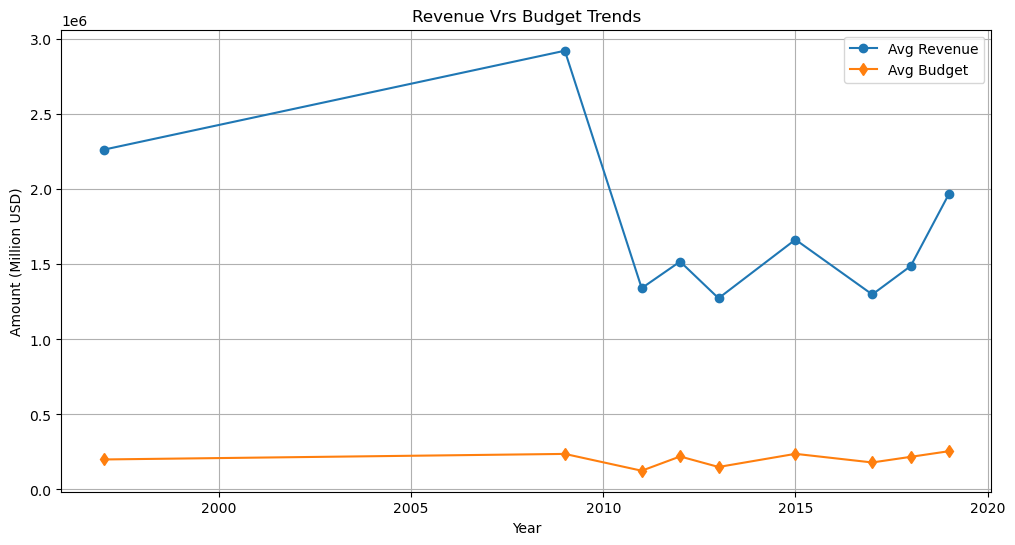

In [34]:


#groupong by year
reordered_df_yearly =reordered_df.withColumn('year', F.year('release_date'))
df_grouped_by_year = reordered_df_yearly.groupby('year').agg(
    F.mean('revenue_musd').alias('average_revenue_musd'),
    F.mean('budget_musd').alias('average_budget_musd')
)

fig, ax = plt.subplots(figsize=(12, 6))
df_grouped_by_year = df_grouped_by_year.toPandas().sort_values('year')
ax.plot(df_grouped_by_year['year'], df_grouped_by_year['average_revenue_musd'], label='Avg Revenue', marker='o')
ax.plot(df_grouped_by_year['year'], df_grouped_by_year['average_budget_musd'], label='Avg Budget', marker='d')
ax.set_ylabel('Amount (Million USD)')
ax.set_xlabel('Year')
ax.set_title('Revenue Vrs Budget Trends')
ax.legend()
ax.grid(True)

### ROI Distribution By Genre

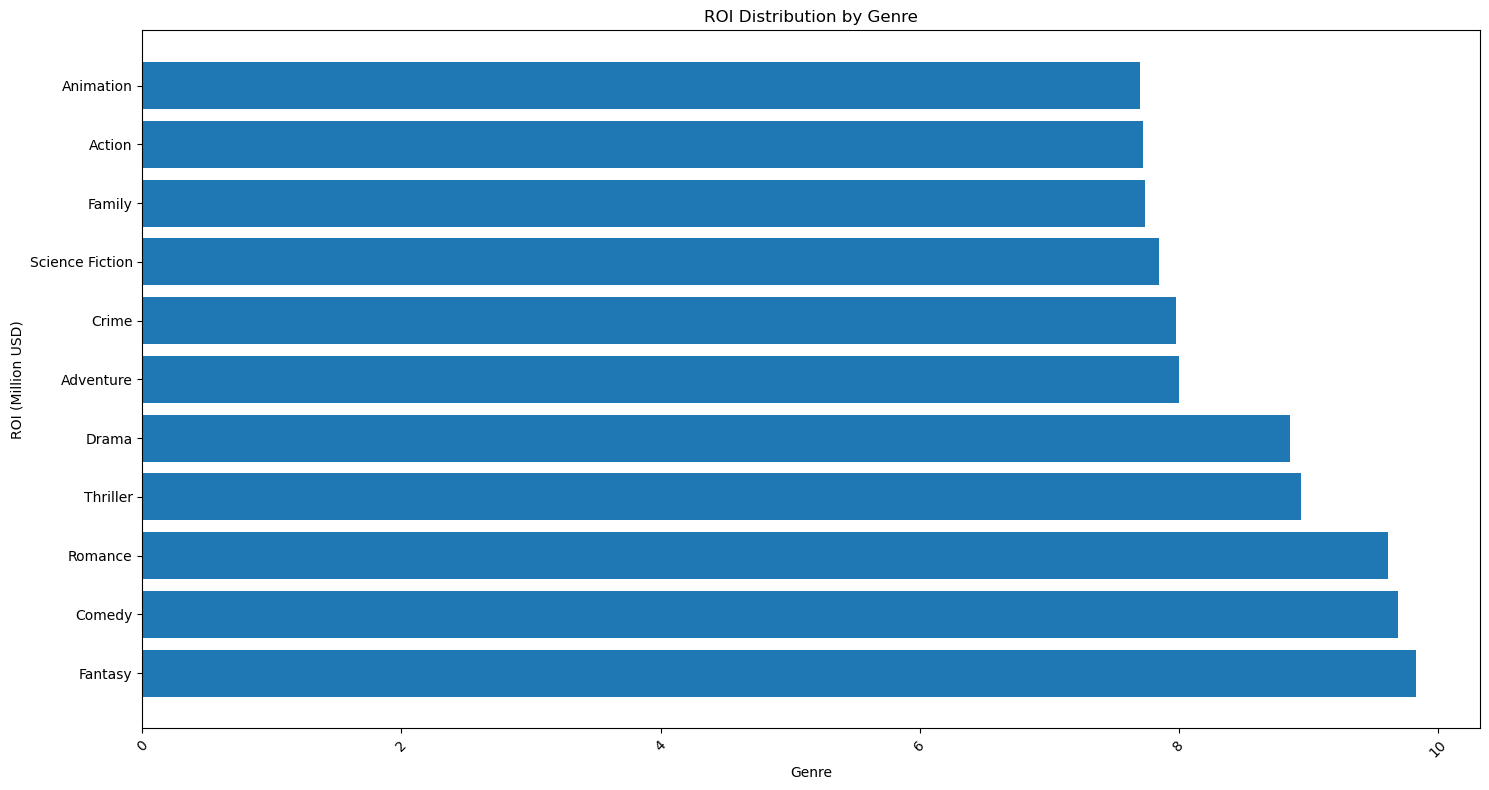

In [36]:

# Split the genres column into a list
reordered_df = reordered_df.withColumn("genres_list", F.split(F.col("genres"), r"\|"))

# Explode the genres list
df_exploded = reordered_df.withColumn("genres_list", F.explode("genres_list"))

# Calculate ROI (Assuming cal_roi is a function you defined to add `roi_musd` column)
reordered_df_with_roi = cal_roi(df_exploded)

# Group by genres and calculate average ROI
highest_roi_by_genre = reordered_df_with_roi.groupBy("genres_list").agg(
    F.mean("roi_musd").alias("avg_roi_musd")
)

# Convert to Pandas for visualization
highest_roi_by_genre_pd = highest_roi_by_genre.toPandas().sort_values("avg_roi_musd", ascending=False)

# Plotting
fig, ax = plt.subplots(figsize=(15, 8))
ax.barh(highest_roi_by_genre_pd['genres_list'], highest_roi_by_genre_pd['avg_roi_musd'])
ax.set_ylabel('ROI (Million USD)')
ax.set_xlabel('Genre')
ax.set_title('ROI Distribution by Genre')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Popularity Vrs Rating


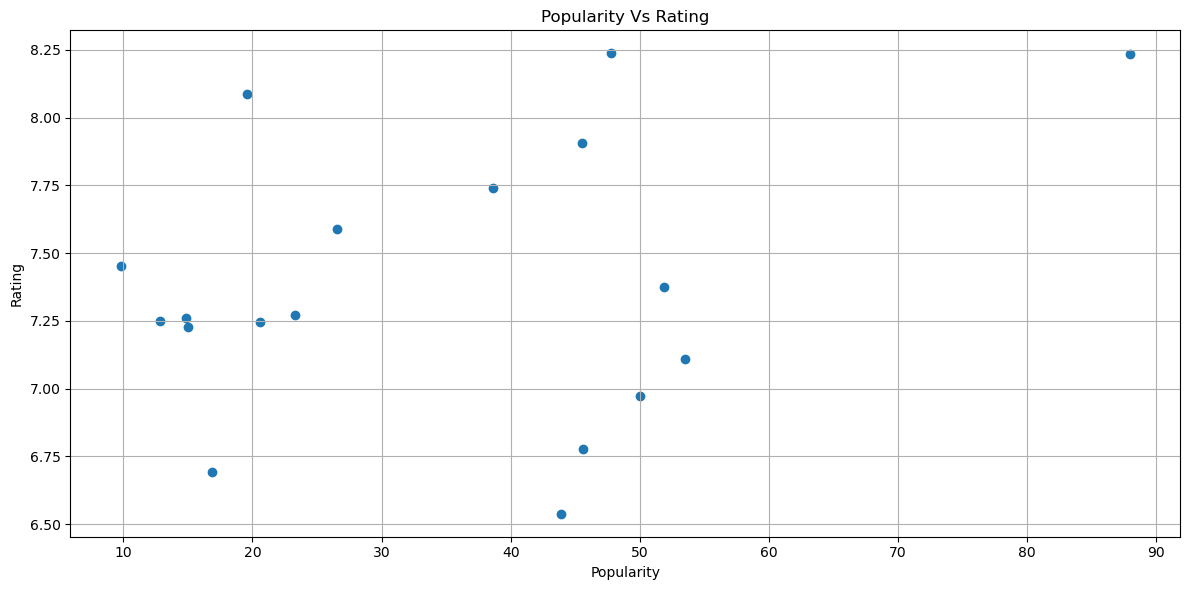

In [42]:
fig, ax = plt.subplots(figsize=(12,6))

popularity_vs_Rating = reordered_df.toPandas()
ax.scatter(popularity_vs_Rating['popularity'], popularity_vs_Rating['vote_average'])
ax.set_ylabel('Rating')
ax.set_xlabel('Popularity')
ax.set_title('Popularity Vs Rating')
ax.grid(True)
plt.tight_layout()
plt.show()

### Yearly Trends in Box Office Perfomance

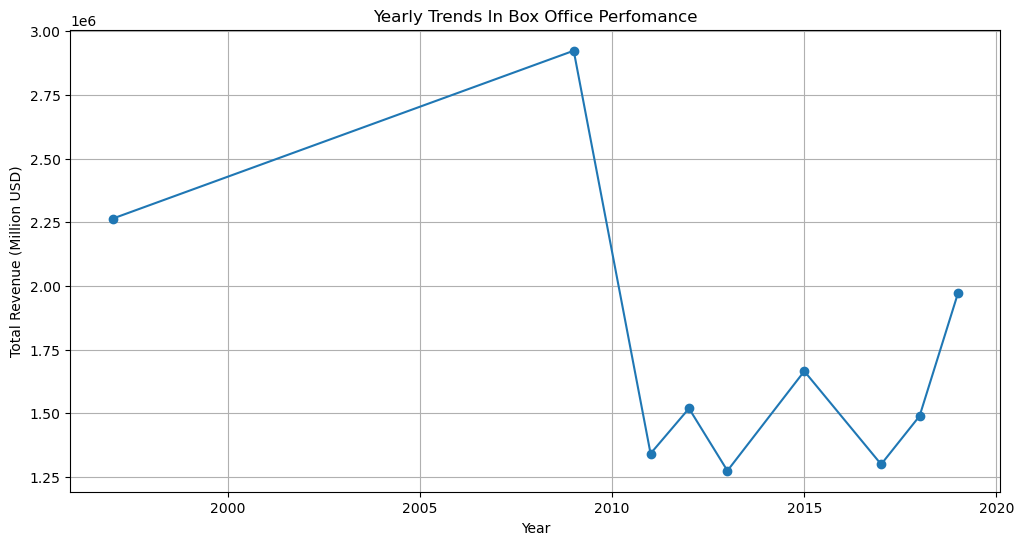

In [45]:

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(df_grouped_by_year['year'], df_grouped_by_year['average_revenue_musd'], label='Avg Revenue', marker='o')
ax.set_ylabel('Total Revenue (Million USD)')
ax.set_xlabel('Year')
ax.set_title('Yearly Trends In Box Office Perfomance')
ax.grid(True)

### Comparison of Franchise vs. Standalone Success 

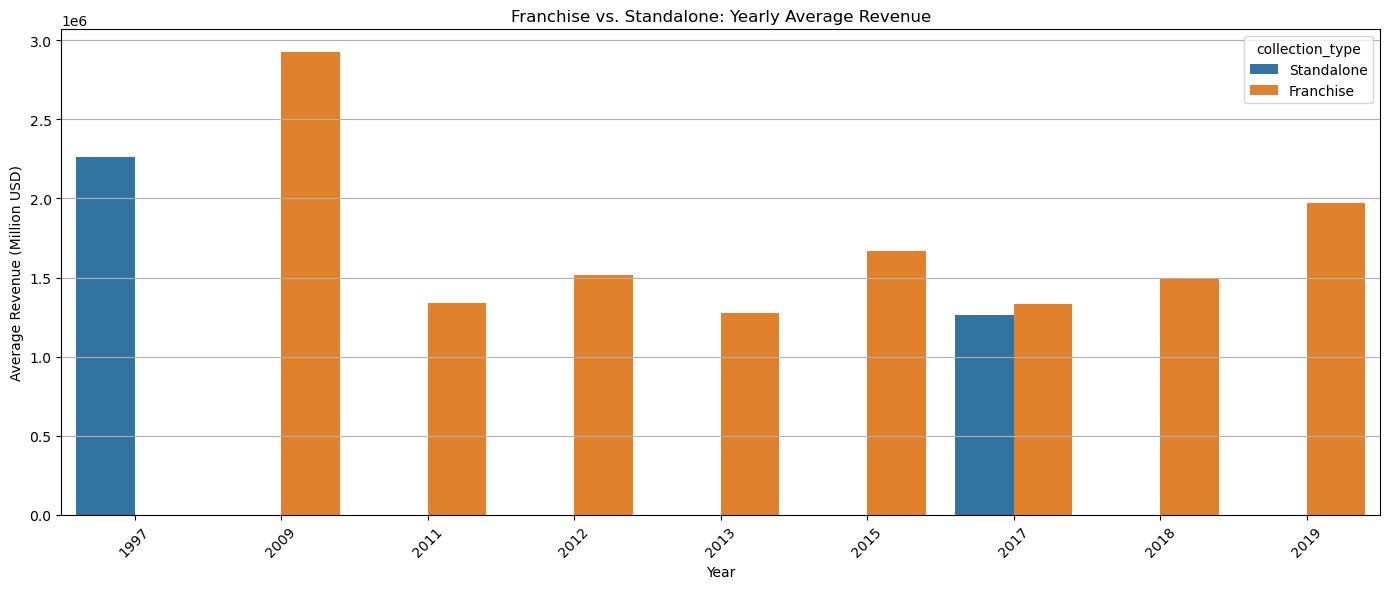

In [49]:
reordered_df = reordered_df.withColumn(
    "collection_type",
    F.when(F.col("belongs_to_collection").isNull(), "Standalone").otherwise("Franchise")
)

# Extract 'year' from release_date if not already done
reordered_df = reordered_df.withColumn("year", F.year("release_date"))

# Group and average by year and collection_type
grouped_df = reordered_df.groupBy("year", "collection_type").agg(
    F.avg("budget_musd").alias("avg_budget_musd"),
    F.avg("revenue_musd").alias("avg_revenue_musd")
)

# Convert to Pandas for Seaborn plotting
grouped_pd = grouped_df.toPandas().sort_values("year")

# Step 5: Plot using Seaborn
plt.figure(figsize=(14, 6))
sns.barplot(
    data=grouped_pd,
    x="year",
    y="avg_revenue_musd",
    hue="collection_type"
)
plt.xlabel("Year")
plt.ylabel("Average Revenue (Million USD)")
plt.title("Franchise vs. Standalone: Yearly Average Revenue")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()